#Initialization

In [1]:
DEVICE = "cpu"

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from torch.distributions.continuous_bernoulli import ContinuousBernoulli

torch.manual_seed(1012)




In [4]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train/255
X_test = X_test/255


train_ds = DatasetWrapper(X_train,y_train)
test_ds = DatasetWrapper(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=10, shuffle=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

## Diffusion model second try

In [ ]:
class Diffusion(nn.Module):
    def __init__(self, data_dim=784, device=DEVICE):
        super(Diffusion, self).__init__()
        self.data_dim = data_dim
        self.device = device
        self.fc1 = nn.Linear(data_dim, data_dim)
        self.fct = nn.Linear(4, data_dim)
        #self.fc1 = nn.Linear(data_dim,49)
        #self.fct = nn.Linear(4,49)

        # Define transposed convolutional layers for upsampling
        #self.trans_conv1 = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1)
        #self.trans_conv2 = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1)

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1)
        )

        #self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.fc_out = nn.Linear(64 * 7 * 7, data_dim)

        #self.fc2 = nn.Linear(32, 32)
        #self.fc3 = nn.Linear(32, 2)
        self.to(device)
        self.conv2d=nn.ConvTranspose2d(1,1,kernel_size=3, stride=1, padding=1 )

    def forward(self, x,t):
        #we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        #we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        #frequency
        omegas = 2*np.pi*torch.tensor([1.0/T,2.0/T,4.0/T,8.0/T]).reshape(1,-1)
        t_embedding = torch.cos(omegas*t.reshape(-1,1))
        #Network structure: a simple network with two hidden layers. the first
        # two fully connected laers are just there to merge the time embedding with the input vector
        x = F.relu(self.fc1(x)+self.fct(t_embedding))
        x = x.reshape(x.shape[0],1,28,28)
        #print("conv2dTranspose", x.shape)
        #x=F.gelu(self.conv1(x))
        #print("conv1", x.shape)
        #print("conv2", x.shape)
        #print("conv3", x.shape)
        #x=F.gelu(self.conv1(x))
        x=self.conv1(x)
        #print("conv4", x.shape)
        x = x.view(-1, 784)
        #print("x", x.shape)
        return x


model = Diffusion()
def weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(weights_init)

In [24]:
model = Diffusion()

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train/255
X_test = X_test/255


train_ds = DatasetWrapper(X_train,y_train)
test_ds = DatasetWrapper(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=10, shuffle=True)

In [25]:
T =200
betas = 0.0035*np.ones(T)
alphas = np.zeros(T)
for t in range(T):
  alphas[t] = (1-0.0035)**t

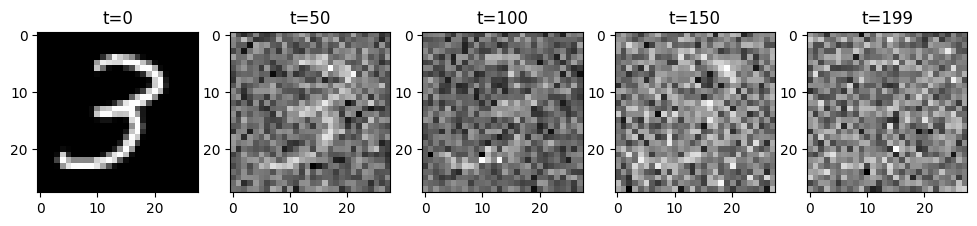

In [10]:
N=len(X_train)
noise_results = []
ts = [0,50,100,150,199]
for a in alphas[ts]:
    x_noise = np.sqrt(a)*X_train + np.sqrt(1-a)*np.random.randn(784*N).reshape(N,784)
    noise_results.append(x_noise)

fig, ax = plt.subplots(1, 5, figsize=(12, 6))
for i, res in enumerate(noise_results):
    ax[i].imshow(res[0,:].reshape(28,28),cmap='gray')
    ax[i].set_title(f"t={ts[i]}")

plt.show()

In [11]:
def loss (Xs, model, T=T, alphas=alphas):
    ts = torch.randint(T, size=(Xs[0].shape[0],)) # pick t uniformly at random
    alpha = torch.tensor(alphas)[ts].reshape(-1,1)
    epsilon = torch.normal(0., 1., size=Xs[0].shape)
    samples = torch.sqrt(alpha)*Xs[0] + torch.sqrt(1-alpha)*epsilon
    eps_model = model.forward(samples.type(torch.float32), ts)

    loss = torch.sum((epsilon-eps_model)**2)/Xs[0].shape[0] # Normalization not contained in Eq.76
    return loss

52500

In [26]:
model = Diffusion()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
num_epochs = 75
for e in range(num_epochs):
  losses = []
  for data in train_loader:
      optimizer.zero_grad()
      l = loss(data,model)
      l.backward()
      optimizer.step()
      losses.append(l.item())

  print("epoch:",e ,"avg loss:", sum(losses)/len(losses), 'min loss',min(losses),'max loss', max(losses))

epoch: 0 avg loss: 1447.5373702528707 min loss 1309.296875 max loss 1598.77490234375
epoch: 1 avg loss: 1238.4765213635692 min loss 1130.4537353515625 max loss 1359.2509765625
epoch: 2 avg loss: 1061.6794355486602 min loss 952.399658203125 max loss 1161.6099853515625
epoch: 3 avg loss: 887.4697015310192 min loss 786.2818603515625 max loss 996.0977172851562
epoch: 4 avg loss: 780.4637311322888 min loss 729.5772705078125 max loss 838.52197265625
epoch: 5 avg loss: 737.4969035723383 min loss 703.8020629882812 max loss 778.0466918945312
epoch: 6 avg loss: 717.1195390458371 min loss 682.3387451171875 max loss 749.145263671875
epoch: 7 avg loss: 699.2042513050588 min loss 660.3782958984375 max loss 732.2108764648438
epoch: 8 avg loss: 682.0206505998034 min loss 645.4219970703125 max loss 720.341796875
epoch: 9 avg loss: 665.9498950835048 min loss 628.3307495117188 max loss 708.8059692382812
epoch: 10 avg loss: 652.1022130953401 min loss 619.7515258789062 max loss 690.4432983398438
epoch: 11 

In [19]:
#Task 3: generate samples from the learned model
#num: number of samples to generate
#model: the trained model
def generate_samples(model, num: int, alphas: np.ndarray=alphas) -> torch.Tensor:
    #Xs = torch.tensor(np.sqrt(alphas[T-1])*X_test[:num] + np.sqrt(1-alphas[T-1])*np.random.randn(784*num).reshape(num,784),dtype=torch.float32)
    Xs =  torch.tensor(X_test[:num])
    #Xs = torch.normal(0.0,1.0,size=(num,784),dtype=torch.float32)
    for t in reversed(range(T)):
        alpha = torch.tensor(alphas)[t]
        beta = torch.tensor(betas[t])
        eps_model = model(Xs, t*torch.ones(num))
        std_model = beta / torch.sqrt(1-alpha)
        mu = (Xs-eps_model*std_model) / torch.sqrt(1-beta)
        Xs = mu + torch.normal(0., 1., size=(num, 784)) * torch.sqrt(beta)
    #print(plt.imshow(mu.reshape(28,28).detach().numpy(), cmap='gray'))
    #print(plt.imshow(Xs.reshape(28,28).detach().numpy(), cmap='gray'))
    #print(plt.imshow(eps_model.reshape(28,28).detach().numpy(), cmap='gray'))
    #print(std_model)
    return Xs
samples = generate_samples(model,1).detach().numpy()

In [ ]:
plt.imshow(samples.reshape(28,28), cmap='gray')

In [ ]:
num_images = 10
reconstructed_images = generate_samples(model,num_images).detach().numpy()

plt.figure(figsize=(24, 8))
for i in range(num_images):
    # Original Images
    plt.subplot(3, num_images, i + 1)
    plt.imshow(test_ds[i][0].reshape(28, 28), cmap='gray')

    plt.title('Original images')
    # Reconstructed Images
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(torch.tensor(np.sqrt(alphas[T-1])*X_test[i] + np.sqrt(1-alphas[T-1])*np.random.randn(784*num_images).reshape(num_images,784),dtype=torch.float32)[0].reshape(28, 28), cmap='gray')
    plt.title('Prior')
    plt.subplot(3, num_images, i + 1 + 2*num_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')


plt.show()